# [CS211A] Homework 2 by Aaron Beomjun Bae, Sakshi Agarwal
Student Number : 49967111, 57642896<br>
Student ID : beomjuna, sakshia1<br>
Due Date : 11:59pm Friday November 1st

In this homework assignment, we will try to answer the following parts in order:
1. Discrete Fourier Transform
2. Notch Filter
3. Analyzing DFT

## Part 1: Discrete Fourier Transform
### a) we follow the given steps to perform Discrete Fourier Transform on an image.
Step 1: Create a 512×512 pixel image.
<br><br>
Step 2: Assume that X and Y are the coordinates of pixels in the above image. Calculate the
value of each pixel using the following equation:
$$I(x,y)=\sin(0.2x)+\sin(0.3x)+\cos(0.4x)+\sin\Big(0.15\sqrt{x^2+y^2}\Big)+\sin\Big(0.35\sqrt{x^2+y^2}\Big)$$
Show your image in the pdf file. 

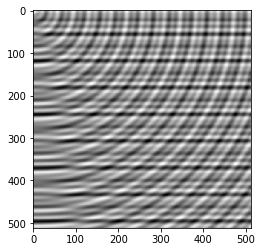

In [7]:
import matplotlib.pyplot as plt
import math
import numpy as np
import cv2

def generateEquationImage(x_pixels, y_pixels):
    newImage = np.zeros((x_pixels, y_pixels));
    # iterate row by column
    for i in range(len(newImage)):
        for j in range(len(newImage[i])):
            newImage[i,j] = math.sin(0.2*i) + math.sin(0.3*i) + math.cos(0.4*i); 
            newImage[i,j] += math.sin(0.15*math.sqrt(i**2+j**2));
            newImage[i,j] += math.sin(0.35*math.sqrt(i**2+j**2));        
    return newImage

# specify size
generated_image = generateEquationImage(512, 512);
plt.imshow(generated_image, cmap='gray');

Step3: Compute the Discrete Fourier Transform of this image. And show the magnitude and
phase of DFT for this image. You can use Matlab functions to calculate the DFT. You should
rearrange the final result to show the zero frequency in the center of the image. For this
purpose you can use “fftshift” function in Matlab.

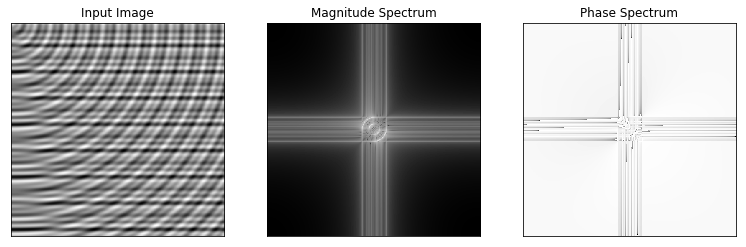

In [2]:
def displayImage(subplot_number, image, title):
    plt.subplot(subplot_number)
    plt.imshow(image, cmap = 'gray')
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    
def plot_dft(image, scale_factor=1, dont_show_plot=False):
    # Only when input is an image
    image = np.float32(image)
    
    # DFT and Shift to center
    dft = cv2.dft(image, flags = cv2.DFT_COMPLEX_OUTPUT) # note (.,.,2) shape due to complex
    dft_shifted = np.fft.fftshift(dft)
    dft_real = dft_shifted[:,:,0]
    dft_imaginary = dft_shifted[:,:,1]
    
    # Log-Scale to Visualize better
    magnitude_spectrum = np.log(cv2.magnitude(dft_real, dft_imaginary))
    phase = np.log(cv2.phase(dft_real, dft_imaginary))
    
    # Visualize
    if not dont_show_plot:
        plt.figure(figsize=(13*scale_factor, 13*scale_factor))
        displayImage(131, image, "Input Image")
        displayImage(132, magnitude_spectrum, "Magnitude Spectrum")
        displayImage(133, phase, "Phase Spectrum")
        plt.show()  
    
    # for step 4
    return dft_shifted

generated_dft = plot_dft(generated_image)

Step4: Multiply the magnitude of DFT with 2 and calculate the inverse Discrete Fourier Transform of it and show the result and explain the difference between the first image that you created in step 2 with this image.

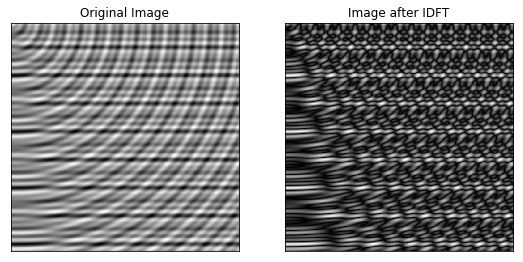

In [23]:
generated_dft = 2*generated_dft

def plot_idft(original_image, dft_shifted, scale_factor=1):
    # Shift to corner and IDFT 
    dft_ishifted = np.fft.ifftshift(dft_shifted)
    idft = cv2.idft(dft_ishifted)
    idft_real = idft[:,:,0]
    idft_imaginary = idft[:,:,1]
    image_reconstructed = cv2.magnitude(idft_real, idft_imaginary)
    
    # Visualize
    plt.figure(figsize=(9*scale_factor, 9*scale_factor))
    displayImage(121, original_image, "Original Image")
    displayImage(122, image_reconstructed, "Image after IDFT")

plot_idft(generated_image, generated_dft)

**A:** The image that results after the inverse DFT is similar, but seems to have lower valleys (lower values of the sine wave). This is most likely due to the 2 we multiplied to the dft.

### b) Show the Discrete Fourier Transform of the following image and explain the pattern in the result in your pdf file.

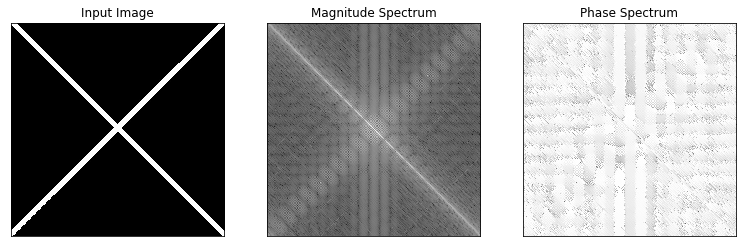

In [4]:
cross = cv2.imread('images/Cross.jpg',cv2.IMREAD_GRAYSCALE)
dft_shifted = plot_dft(cross)

**A:** We can see that there is a white diagonal line in the magnitude image. This is because of the edge that exists in the original image.

## Part 2: Notch Filter
Use the following images from the image gallery and try to develop your own band-stop filter to remove the noise. For this purpose you should calculate the DFT of the image and remove a specific range of frequencies and then calculate the inverse DFT. You need to test different frequency intervals to find the best filter. (the final results might not be perfect but you should clearly see the noise reduce). Show the final result in the PDF file. 

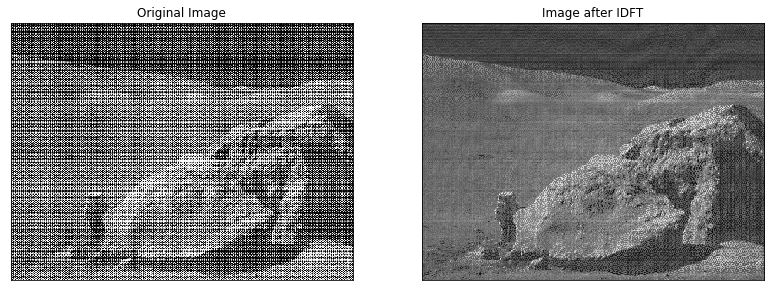

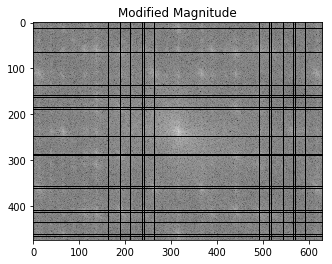

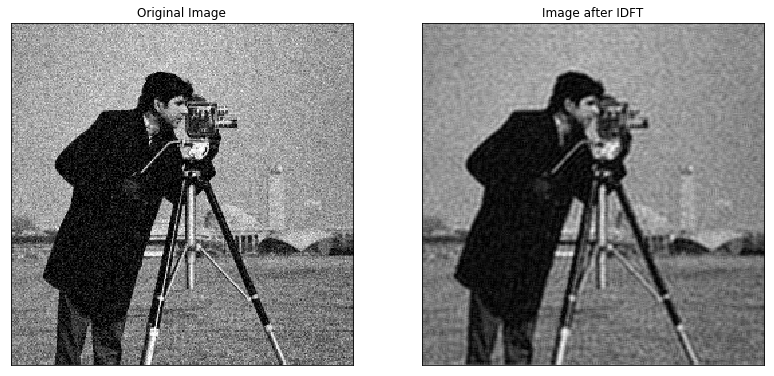

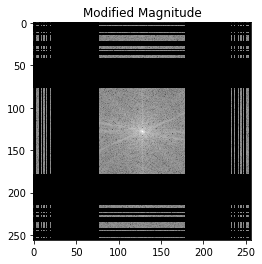

In [21]:
def standard_notch(magnitude, safe_window, threshold_offset):
    threshold = np.mean(magnitude) + threshold_offset
    center_x = int(len(magnitude)/2)
    center_y = int(len(magnitude[0])/2)
    # array of bools
    amp_high_horizontal = np.where(np.max(magnitude, axis=1) > threshold)[0]
    amp_high_vertical = np.where(np.max(magnitude, axis=0) > threshold)[0]
    # array of indices with safe window removed
    amp_high_horizontal = amp_high_horizontal[np.logical_or(amp_high_horizontal < center_x-safe_window, amp_high_horizontal > center_x+safe_window)]
    amp_high_vertical = amp_high_vertical[np.logical_or(amp_high_vertical < center_y-safe_window, amp_high_vertical > center_y+safe_window)]
    # apply the filter
    magnitude[amp_high_horizontal,:] = 0
    magnitude[:,amp_high_vertical] = 0
    return magnitude
   
def plotNotchFilter(image_name, safe_window, threshold_offset):
    # read image and DFT
    image = cv2.imread(image_name,cv2.IMREAD_GRAYSCALE)
    dft_shifted = plot_dft(image, 1.2, True)
    
    # create magnitude and phase
    dft_real = dft_shifted[:,:,0]
    dft_imaginary = dft_shifted[:,:,1]
    magnitude_spectrum = np.log(cv2.magnitude(dft_real, dft_imaginary))
    phase = np.log(cv2.phase(dft_real, dft_imaginary))
    
    # modify somehow
    modified_magnitude = magnitude_spectrum[:,:]
    modified_magnitude = standard_notch(modified_magnitude, safe_window, threshold_offset)
    
    # Bring DFT back from magnitude
    modified_dft_real = np.exp(modified_magnitude)*np.cos(np.exp(phase))
    modified_dft_imaginary = np.exp(modified_magnitude)*np.sin(np.exp(phase))
    modified_dft = np.stack((modified_dft_real, modified_dft_imaginary), axis=2)
    
    # IDFT
    plot_idft(image, modified_dft, 1.5)
    
    plt.figure();    
    plt.imshow(modified_magnitude, cmap="gray")
    plt.title("Modified Magnitude")
    
plotNotchFilter("images/moonlanding.png", 10, 3.6);
plotNotchFilter("images/psnr2.png", 50, 1);

## Part 3: Analyzing DFT
Choose a 64x64 image and find the Discrete Fourier Transform for the image. Now Add 64 columns and rows of zeros to the right and bottom side of the original image. Now find the DFT of this new image again. Repeat this process 2 more times each time doubling the image size and padding the pixels on the right and bottom by zeroes. You will therefore have 4 images – first one 64 x 64 with no zero padding and then 128x128, 256x256 and 512 x 512 after padding. Find the DFTs of all these images. Show all your results in the pdf file and explain the relationship between the four DFTs you get. Justify the relationship you discover.

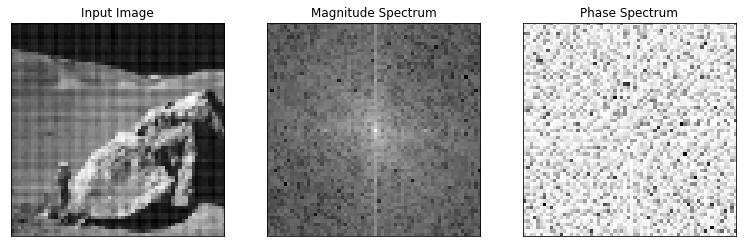

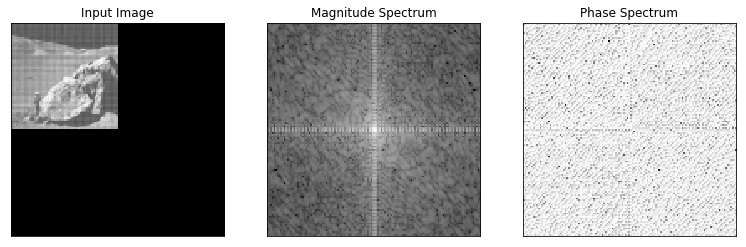

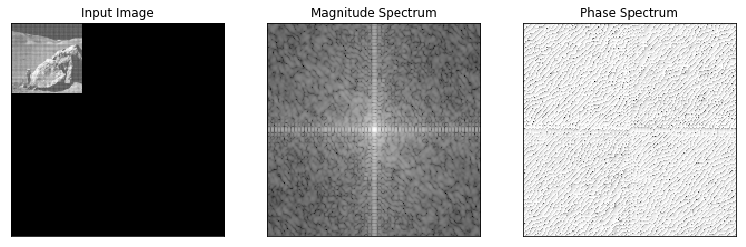

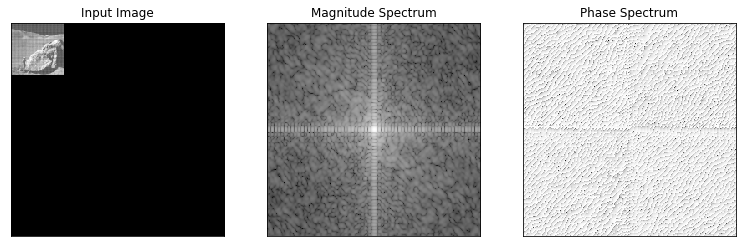

In [6]:
moonlanding = cv2.imread("images/moonlanding.png",cv2.IMREAD_GRAYSCALE)
moonlanding = cv2.resize(moonlanding, (64,64), interpolation = cv2.INTER_AREA)

for i in np.arange(4):
    dft = plot_dft(moonlanding)
    moonlanding = np.pad(moonlanding, (0, 64), 'constant', constant_values=(0,0))

**A:** The resulting magnitude image is surprisingly not changed that much. This is most likely because the same frequency needs to exist in order for the same image to appear no matter the location of the thumbnail. However, we can see that the phase seems to have clear boundaries for 4 quadrants. This is likely because the phase is responsible for moving the thumbnails to different locations within the original images.